In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


comp classify 60 secs datad thus justifing a persons state 1st and 2nd.

train.csv contains
* ~26k entries (rows)
* of 60 sec (time gaps)(subrows)
* 13 biological sensors (columns)
* for 1k experimental participants(test cases)(plus dont know how this effects the outcomes)

In [27]:
train=pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test=pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
import time, logging, gc
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import roc_auc_score

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import KFold, GroupKFold
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt   

from tqdm.notebook import tqdm



from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import pandas as pd, numpy as np

In [29]:
train_labels=pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

In [30]:
import numpy as np
import pandas as pd
features  = [col for col in test.columns if col not in ("sequence","step","subject")]

train = pd.merge(train, train_labels,how='left', on="sequence")

In [31]:
 
def addFeatures(df):  
    for feature in features:
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
        df.fillna(0, inplace=True)
        df[feature + '_diff1'] = df[feature] - df[feature + '_lag1']    
    return df


train = addFeatures(train)
test = addFeatures(test)

In [32]:
train

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
0               0       47     0  -0.196291   0.112395   1.000000   0.329204   
1               0       47     1  -0.447450   0.134454   1.000000  -0.658407   
2               0       47     2   0.326893  -0.694328   1.000000   0.330088   
3               0       47     3   0.523184   0.751050   1.000000   0.976991   
4               0       47     4   0.272025   1.074580   1.000000  -0.136283   
...           ...      ...   ...        ...        ...        ...        ...   
1558075     25967      327    55  -0.282844  -1.217437  -1.666153   0.586726   
1558076     25967      327    56   0.130603   0.349790  -1.666153  -0.324779   
1558077     25967      327    57  -0.579598   0.429622  -1.666153   0.319469   
1558078     25967      327    58   1.278980   1.711134  -1.522820   0.802655   
1558079     25967      327    59  -1.136012  -3.702731  -1.332820  -0.766372   

         sensor_04  sensor_05  sensor_06  ...  sensor_08_lag1  \
0        -1.004660  -0.131638  -0.127505  ...             0.0   
1         0.162495   0.340314  -0.209472  ...            -0.1   
2         0.473678   1.280479  -0.094718  ...             0.2   
3        -0.563287  -0.720269   0.793260  ...             1.4   
4         0.398579   0.044877   0.560109  ...            -0.3   
...            ...        ...        ...  ...             ...   
1558075  -0.930698  -0.451010  -0.651184  ...            -1.2   
1558076   0.775324  -0.332835   0.099271  ...             0.4   
1558077   0.308861   0.282723  -0.512750  ...            -0.2   
1558078  -0.460541  -0.055348   2.405282  ...            -1.6   
1558079  -0.430027  -0.091997  -2.512750  ...             1.9   

         sensor_08_diff1  sensor_09_lag1  sensor_09_diff1  sensor_10_lag1  \
0                   -0.1        0.000000        -0.963873        0.000000   
1                    0.3       -0.963873         0.662572       -0.985069   
2                    1.2       -0.301301         1.303468        0.082733   
3                   -1.7        1.002168        -1.997832        0.449221   
4                   -0.6       -0.995665         2.051301       -0.434290   
...                  ...             ...              ...             ...   
1558075              1.6       -0.647399         0.656069       -0.596996   
1558076             -0.6        0.008671         0.635838       -0.723536   
1558077             -1.4        0.644509        -1.068642        0.691407   
1558078              3.5       -0.424133         0.708092        0.716855   
1558079             -3.0        0.283960        -0.937861       -0.914914   

         sensor_10_diff1  sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  \
0              -0.985069        0.000000         0.531893        0.000000   
1               1.067802        0.531893        -0.763374        4.751492   
2               0.366488       -0.231481        -0.354938        0.454390   
3              -0.883512       -0.586420         1.931070       -4.736147   
4               1.246921        1.344650        -1.221193        0.429241   
...                  ...             ...              ...             ...   
1558075        -0.126540       -0.728395         0.374486        0.639812   
1558076         1.414943       -0.353909        -0.259259       -0.914749   
1558077         0.025447       -0.613169         2.241770       -0.515772   
1558078        -1.631769        1.628601        -1.264403        0.928389   
1558079         0.496398        0.364198        -1.817901        0.211424   

         sensor_12_diff1  
0               4.751492  
1              -4.297101  
2              -5.190537  
3               5.165388  
4              -0.652600  
...                  ...  
1558075        -1.554561  
1558076         0.398977  
1558077         1.444160  
1558078        -0.716965  
1558079        -1.772805  

[1558080 rows x 43 columns]

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1558080 entries, 0 to 1558079
Data columns (total 43 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   sequence         1558080 non-null  int64  
 1   subject          1558080 non-null  int64  
 2   step             1558080 non-null  int64  
 3   sensor_00        1558080 non-null  float64
 4   sensor_01        1558080 non-null  float64
 5   sensor_02        1558080 non-null  float64
 6   sensor_03        1558080 non-null  float64
 7   sensor_04        1558080 non-null  float64
 8   sensor_05        1558080 non-null  float64
 9   sensor_06        1558080 non-null  float64
 10  sensor_07        1558080 non-null  float64
 11  sensor_08        1558080 non-null  float64
 12  sensor_09        1558080 non-null  float64
 13  sensor_10        1558080 non-null  float64
 14  sensor_11        1558080 non-null  float64
 15  sensor_12        1558080 non-null  float64
 16  state            1

In [34]:
a=train.groupby(sort=False,by="sequence").mean()

In [35]:
a=train.subject.unique()
a=np.array(a)
len(a)

672

In [36]:
a.sort()
l=a==[i for i in range(0,672)]
if l.all():
    print("TRue")
    

TRue


In [37]:
train_labels
train[["sequence","subject"]].iloc[60:60+60] 
#implication --> sequence corresponds to an explicit subjects
#train=train.drop("subject",axis=1)
train

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
0               0       47     0  -0.196291   0.112395   1.000000   0.329204   
1               0       47     1  -0.447450   0.134454   1.000000  -0.658407   
2               0       47     2   0.326893  -0.694328   1.000000   0.330088   
3               0       47     3   0.523184   0.751050   1.000000   0.976991   
4               0       47     4   0.272025   1.074580   1.000000  -0.136283   
...           ...      ...   ...        ...        ...        ...        ...   
1558075     25967      327    55  -0.282844  -1.217437  -1.666153   0.586726   
1558076     25967      327    56   0.130603   0.349790  -1.666153  -0.324779   
1558077     25967      327    57  -0.579598   0.429622  -1.666153   0.319469   
1558078     25967      327    58   1.278980   1.711134  -1.522820   0.802655   
1558079     25967      327    59  -1.136012  -3.702731  -1.332820  -0.766372   

         sensor_04  sensor_05  sensor_06  ...  sensor_08_lag1  \
0        -1.004660  -0.131638  -0.127505  ...             0.0   
1         0.162495   0.340314  -0.209472  ...            -0.1   
2         0.473678   1.280479  -0.094718  ...             0.2   
3        -0.563287  -0.720269   0.793260  ...             1.4   
4         0.398579   0.044877   0.560109  ...            -0.3   
...            ...        ...        ...  ...             ...   
1558075  -0.930698  -0.451010  -0.651184  ...            -1.2   
1558076   0.775324  -0.332835   0.099271  ...             0.4   
1558077   0.308861   0.282723  -0.512750  ...            -0.2   
1558078  -0.460541  -0.055348   2.405282  ...            -1.6   
1558079  -0.430027  -0.091997  -2.512750  ...             1.9   

         sensor_08_diff1  sensor_09_lag1  sensor_09_diff1  sensor_10_lag1  \
0                   -0.1        0.000000        -0.963873        0.000000   
1                    0.3       -0.963873         0.662572       -0.985069   
2                    1.2       -0.301301         1.303468        0.082733   
3                   -1.7        1.002168        -1.997832        0.449221   
4                   -0.6       -0.995665         2.051301       -0.434290   
...                  ...             ...              ...             ...   
1558075              1.6       -0.647399         0.656069       -0.596996   
1558076             -0.6        0.008671         0.635838       -0.723536   
1558077             -1.4        0.644509        -1.068642        0.691407   
1558078              3.5       -0.424133         0.708092        0.716855   
1558079             -3.0        0.283960        -0.937861       -0.914914   

         sensor_10_diff1  sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  \
0              -0.985069        0.000000         0.531893        0.000000   
1               1.067802        0.531893        -0.763374        4.751492   
2               0.366488       -0.231481        -0.354938        0.454390   
3              -0.883512       -0.586420         1.931070       -4.736147   
4               1.246921        1.344650        -1.221193        0.429241   
...                  ...             ...              ...             ...   
1558075        -0.126540       -0.728395         0.374486        0.639812   
1558076         1.414943       -0.353909        -0.259259       -0.914749   
1558077         0.025447       -0.613169         2.241770       -0.515772   
1558078        -1.631769        1.628601        -1.264403        0.928389   
1558079         0.496398        0.364198        -1.817901        0.211424   

         sensor_12_diff1  
0               4.751492  
1              -4.297101  
2              -5.190537  
3               5.165388  
4              -0.652600  
...                  ...  
1558075        -1.554561  
1558076         0.398977  
1558077         1.444160  
1558078        -0.716965  
1558079        -1.772805  

[1558080 rows x 43 columns]

In [38]:
train_sequence=[]
train_labels

sequence  state
0             0      0
1             1      1
2             2      1
3             3      1
4             4      1
...         ...    ...
25963     25963      1
25964     25964      0
25965     25965      1
25966     25966      1
25967     25967      0

[25968 rows x 2 columns]

In [39]:
for i in train.groupby(sort=False,by="sequence"):
    train_sequence.append(i)
train_sequence[1][1].head()

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
60         1       66     0  -6.657651  -0.141807  -2.332306  -0.715929   
61         1       66     1   1.633694   0.586134  -2.127622   5.637168   
62         1       66     2   1.863215  -2.143908  -1.999486  -4.159292   
63         1       66     3  -2.846213   2.011555  -1.999486  -1.711504   
64         1       66     4   0.593509  -0.613445  -1.999486   0.957522   

    sensor_04  sensor_05  sensor_06  ...  sensor_08_lag1  sensor_08_diff1  \
60   0.789225  -0.483919  -4.568306  ...             0.0             -0.1   
61   0.613359  -1.287958  -0.885246  ...            -0.1              0.6   
62  -1.417513   1.674645   2.775046  ...             0.5             -1.7   
63  -1.344486  -4.602842  -3.163024  ...            -1.2              3.2   
64   0.457159   4.559461   2.064663  ...             2.0             -3.8   

    sensor_09_lag1  sensor_09_diff1  sensor_10_lag1  sensor_10_diff1  \
60        0.000000        -3.517341        0.000000         1.168139   
61       -3.517341         4.149566        1.168139         0.013479   
62        0.632225         0.838873        1.181617        -3.100540   
63        1.471098        -3.272399       -1.918923         0.642749   
64       -1.801301         2.054913       -1.276174         2.712323   

    sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  sensor_12_diff1  
60        0.000000         1.524691        0.000000       -12.446718  
61        1.524691         0.862140      -12.446718        96.937766  
62        2.386831        -5.898148       84.491049      -120.429241  
63       -3.511317         4.363169      -35.938193      -124.296249  
64        0.851852        -0.740741     -160.234442       151.089088  

[5 rows x 43 columns]

In [40]:
def call(df,seq):
    return df[seq][1]
call(train_sequence,1).head()

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
60         1       66     0  -6.657651  -0.141807  -2.332306  -0.715929   
61         1       66     1   1.633694   0.586134  -2.127622   5.637168   
62         1       66     2   1.863215  -2.143908  -1.999486  -4.159292   
63         1       66     3  -2.846213   2.011555  -1.999486  -1.711504   
64         1       66     4   0.593509  -0.613445  -1.999486   0.957522   

    sensor_04  sensor_05  sensor_06  ...  sensor_08_lag1  sensor_08_diff1  \
60   0.789225  -0.483919  -4.568306  ...             0.0             -0.1   
61   0.613359  -1.287958  -0.885246  ...            -0.1              0.6   
62  -1.417513   1.674645   2.775046  ...             0.5             -1.7   
63  -1.344486  -4.602842  -3.163024  ...            -1.2              3.2   
64   0.457159   4.559461   2.064663  ...             2.0             -3.8   

    sensor_09_lag1  sensor_09_diff1  sensor_10_lag1  sensor_10_diff1  \
60        0.000000        -3.517341        0.000000         1.168139   
61       -3.517341         4.149566        1.168139         0.013479   
62        0.632225         0.838873        1.181617        -3.100540   
63        1.471098        -3.272399       -1.918923         0.642749   
64       -1.801301         2.054913       -1.276174         2.712323   

    sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  sensor_12_diff1  
60        0.000000         1.524691        0.000000       -12.446718  
61        1.524691         0.862140      -12.446718        96.937766  
62        2.386831        -5.898148       84.491049      -120.429241  
63       -3.511317         4.363169      -35.938193      -124.296249  
64        0.851852        -0.740741     -160.234442       151.089088  

[5 rows x 43 columns]

# seperating indexes for 1's and 0's reading to understand the data

In [41]:
train_labels
zeros_index=[]
ones_index=[]
for i in range(len(train_labels)):
    if train_labels["state"].iloc[i]==1:
        ones_index.append(i)
    else:
        zeros_index.append(i)
print(len(ones_index),len(zeros_index))

13014 12954


almost equal ones and zeros to train :)

# visualising senosory data

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
features_sen=[i for i in train.columns if "sensor" in i]
#call(train_sequence,j)["sensor_00"]

# superimposed reading

In [44]:
def super_imp(arr,tt=train_sequence):
    for i in features_sen:
        plt.figure(figsize=(18, 3))
        for j in arr:#add any to the bracket for comparing in one
            l=call(tt,j)
            l=l.set_index("step")
            plt.plot(l[i])#x=60,y=values of column
        plt.legend(arr)
        plt.title(str(i))
        plt.show()

# comparsion

In [45]:
from random import shuffle

# displaying ones

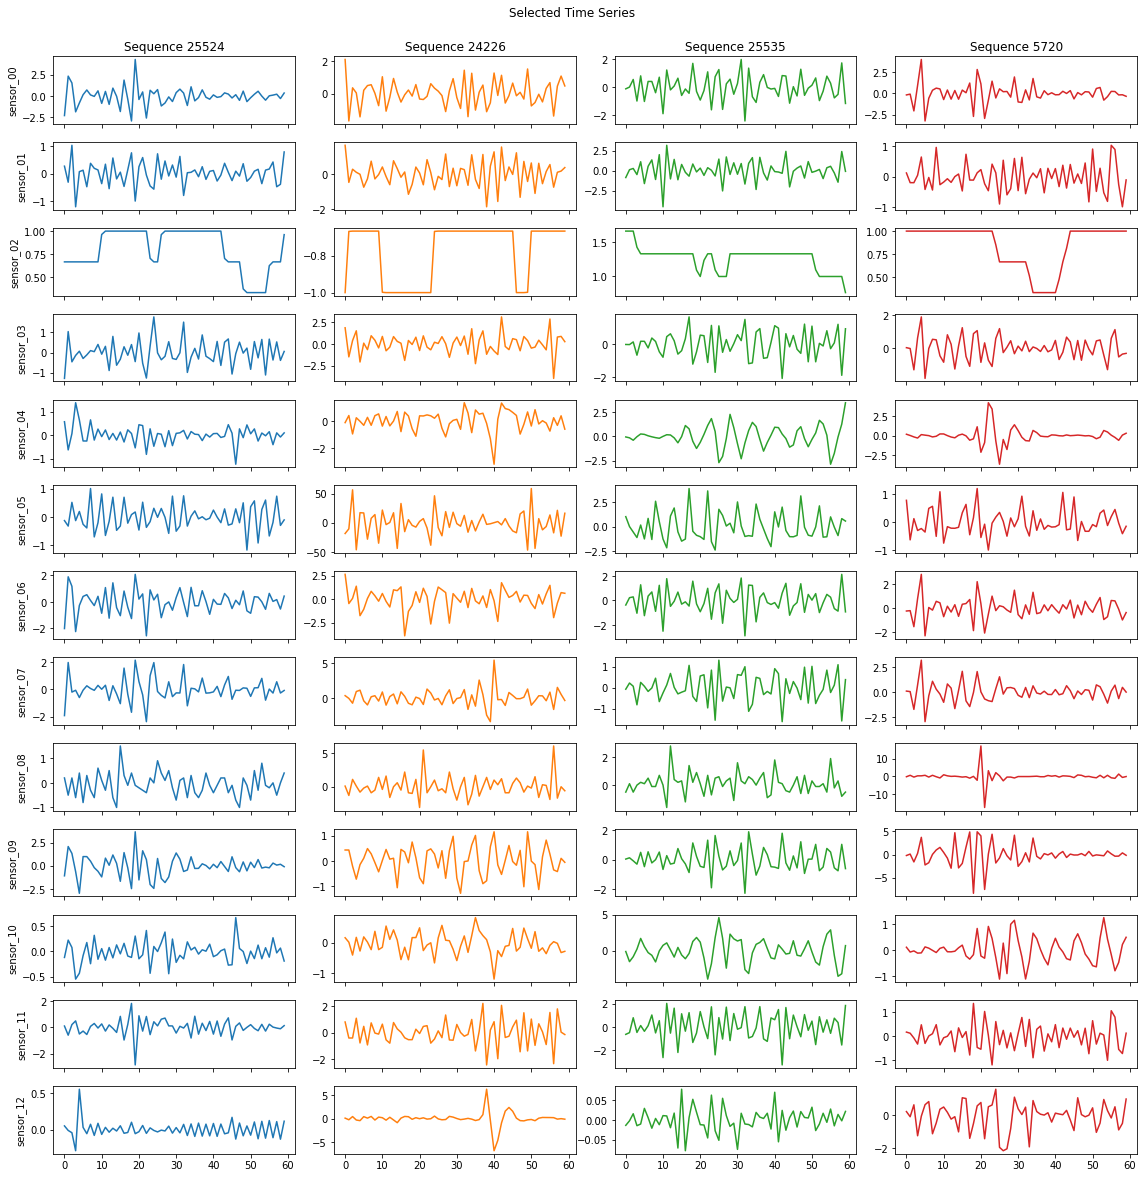

       state
25524      1
24226      1
25535      1
5720       1


In [46]:
train_df=train.copy()
features=features_sen
shuffle(ones_index)
sequences = ones_index[:4]#[0, 1, 2, 8364, 15404,]
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(16, 16))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f"sensor_{sensor:02d}"
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train_df[train_df.sequence == sequence][sensor_name],
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
        if sensor == 0: plt.title(f"Sequence {sequence}")
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Selected Time Series', y=1.02)
plt.show()
print(train_labels.loc[sequences,["state"]])
sequences_1=sequences

# displaying zeros

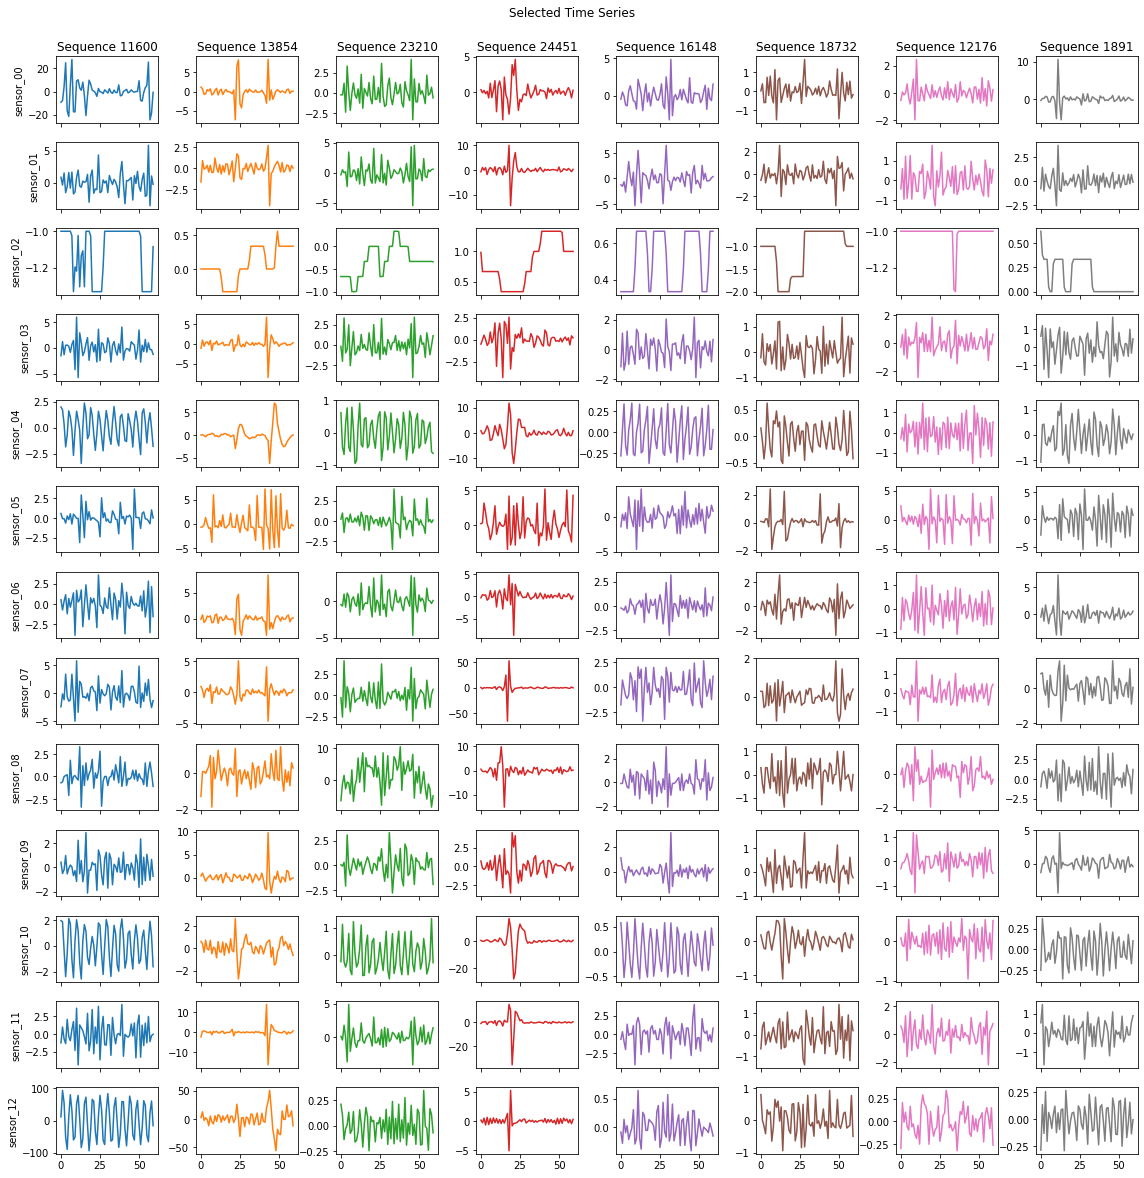

       state
11600      0
13854      0
23210      0
24451      0
16148      0
18732      0
12176      0
1891       0


In [47]:
train_df=train.copy()
features=features_sen
shuffle(zeros_index)
sequences_0 = zeros_index[:8]#[0, 1, 2, 8364, 15404,]
sequences=sequences_0
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(16, 16))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f"sensor_{sensor:02d}"
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train_df[train_df.sequence == sequence][sensor_name],
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i % 10])
        if sensor == 0: plt.title(f"Sequence {sequence}")
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Selected Time Series', y=1.02)
plt.show()
print(train_labels.loc[sequences_0,["state"]])

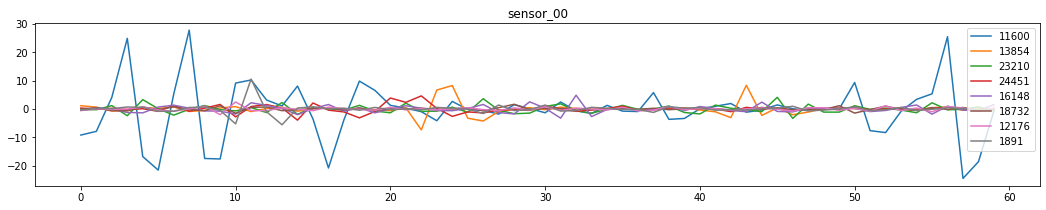

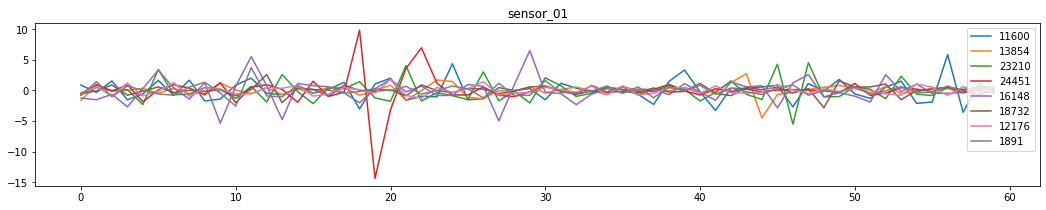

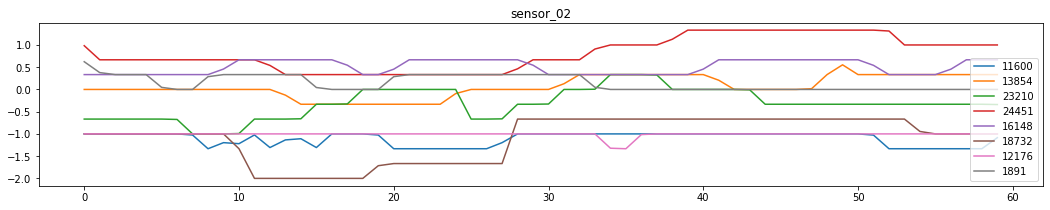

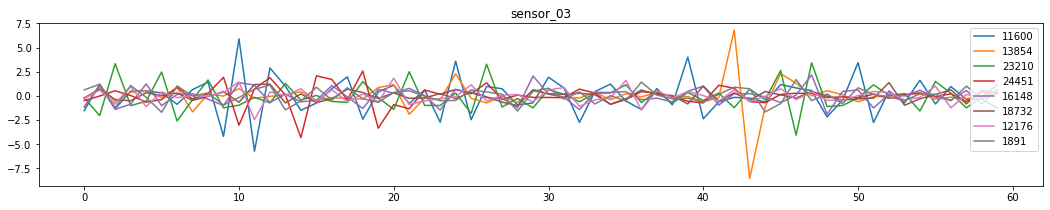

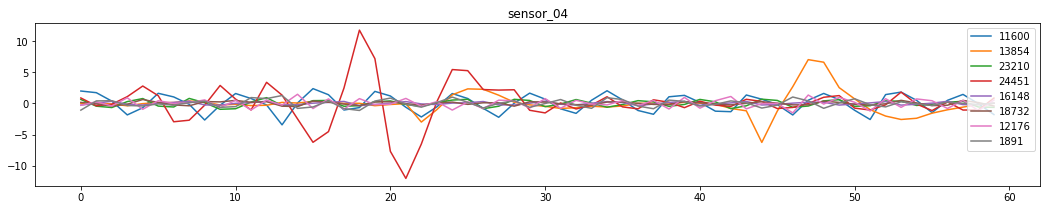

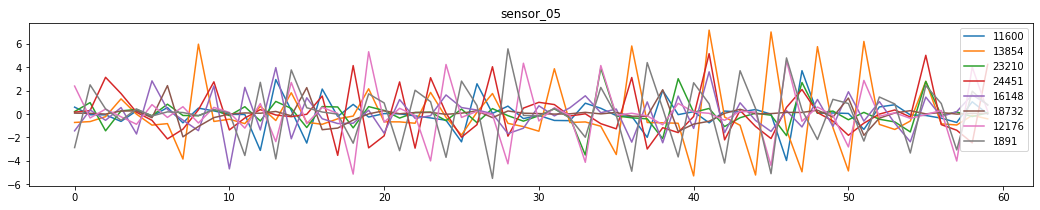

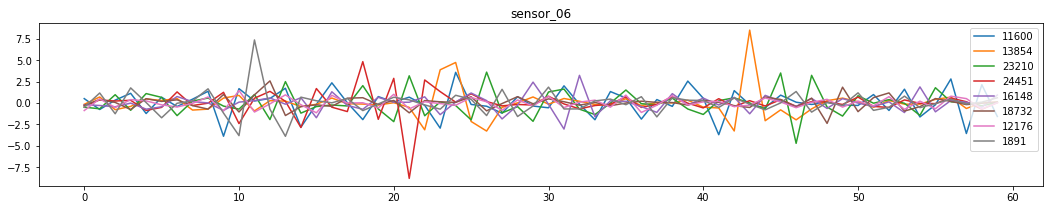

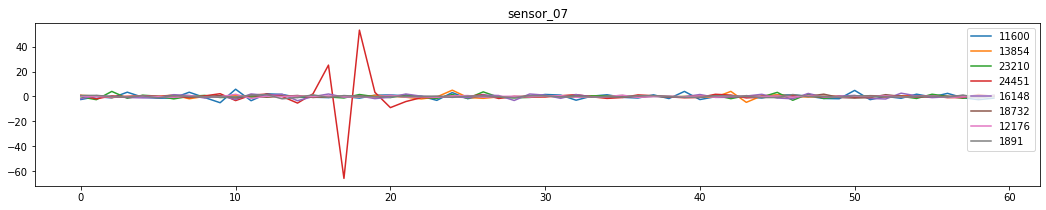

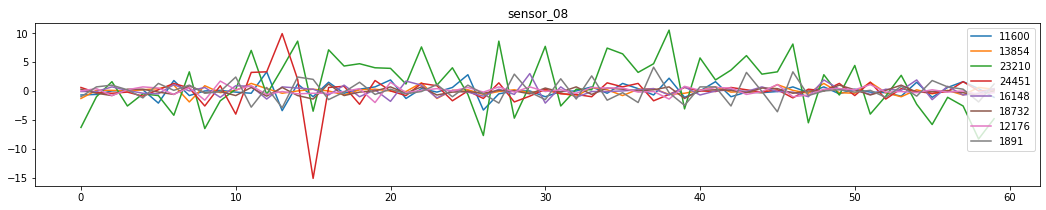

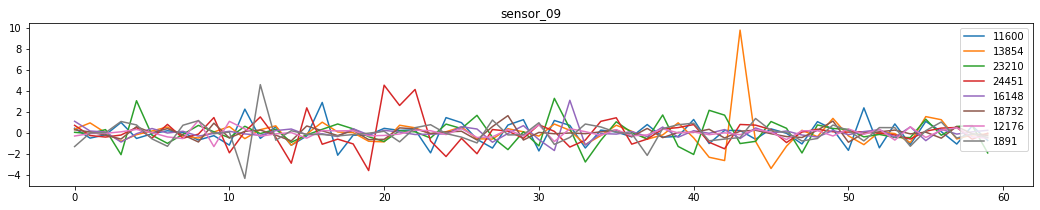

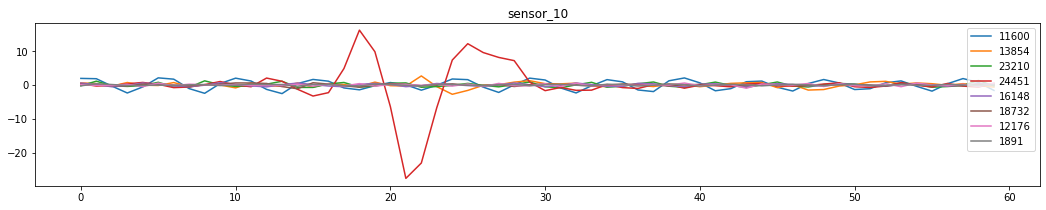

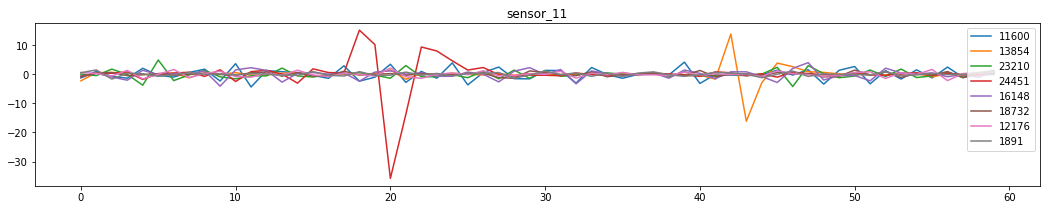

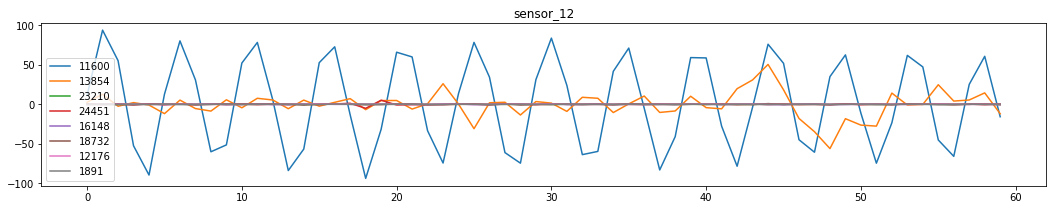

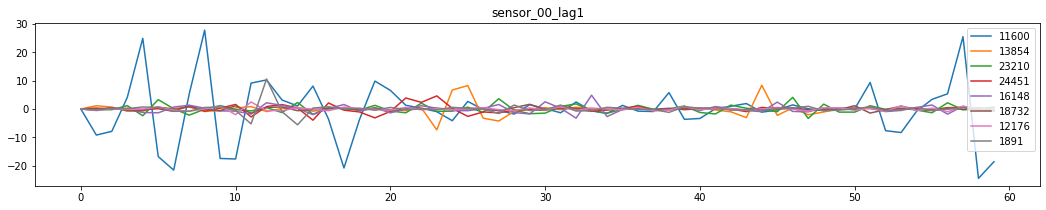

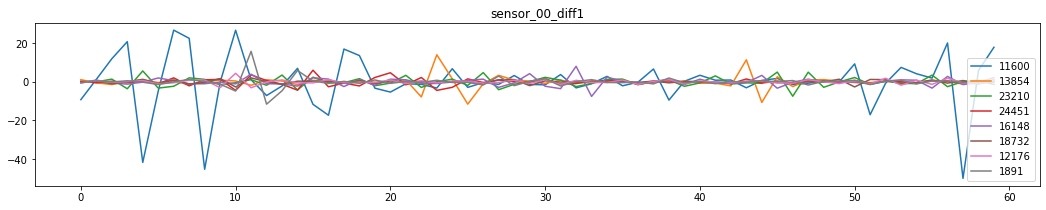

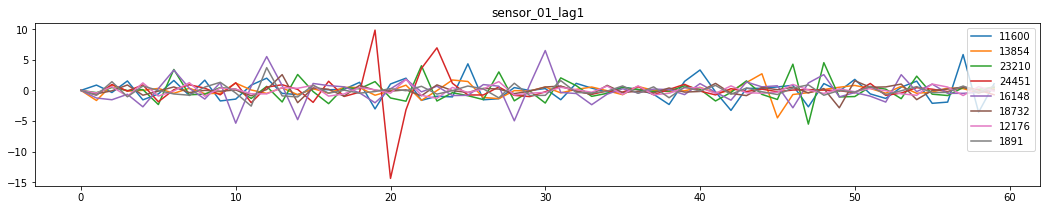

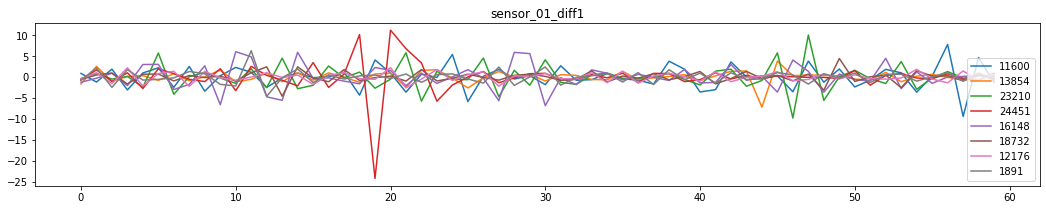

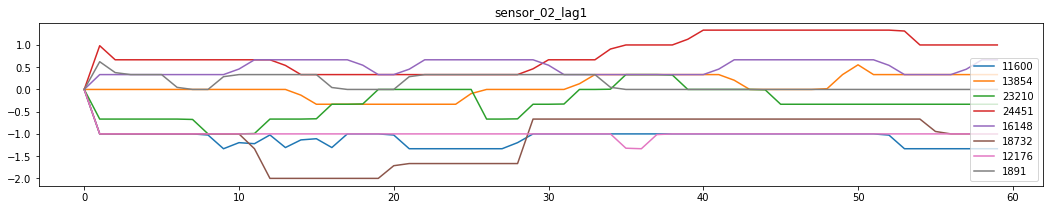

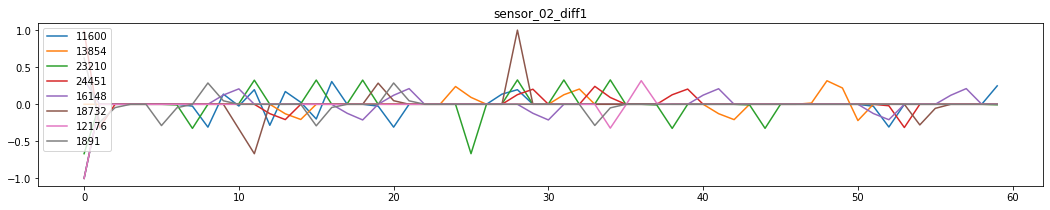

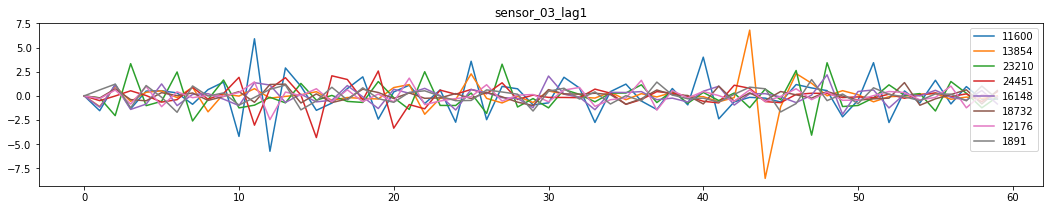

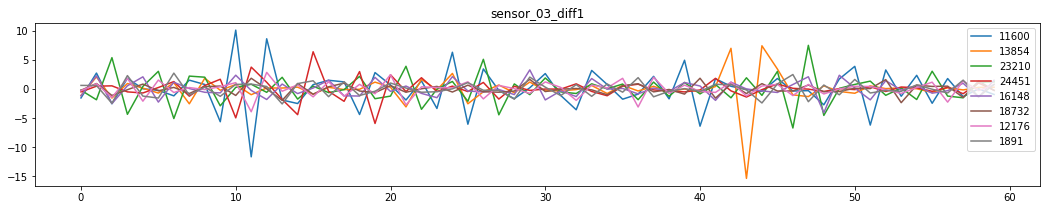

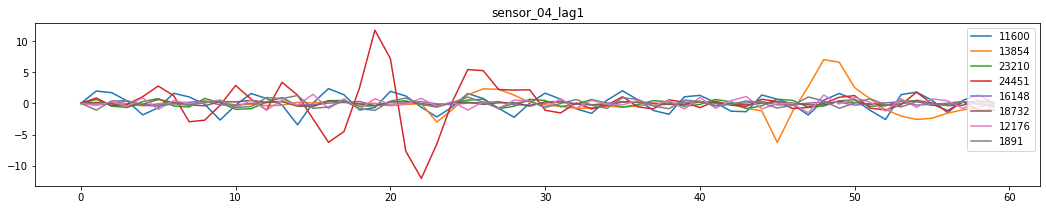

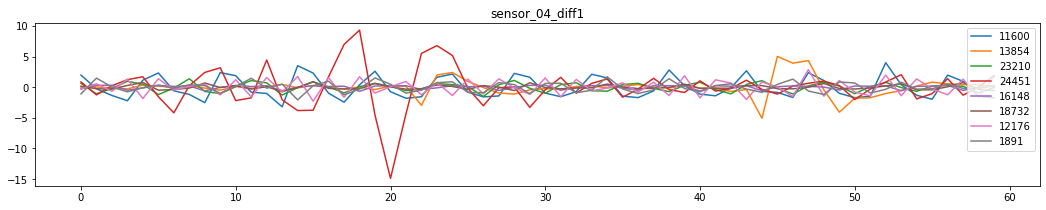

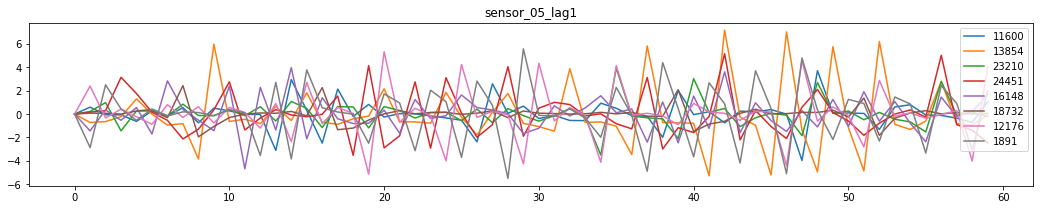

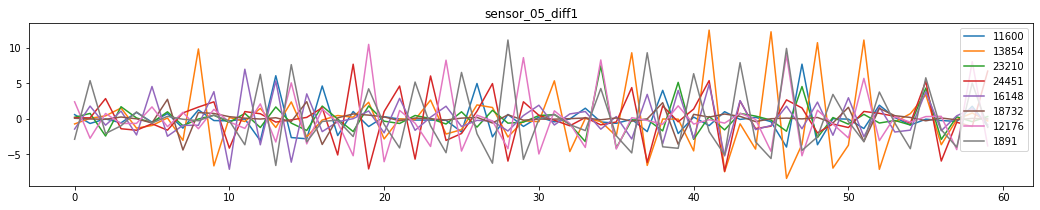

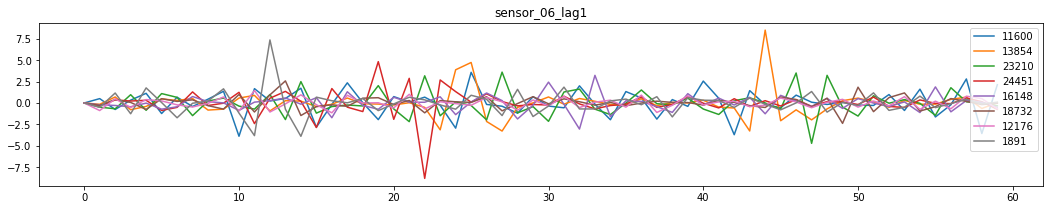

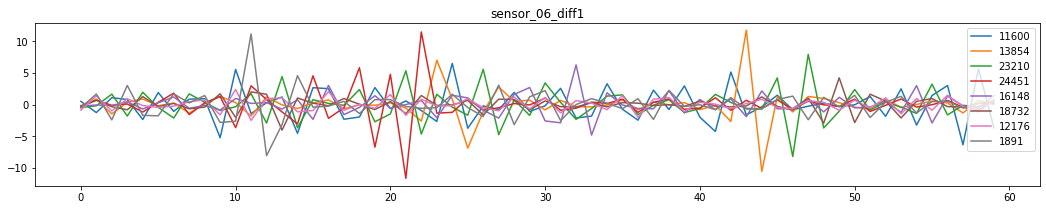

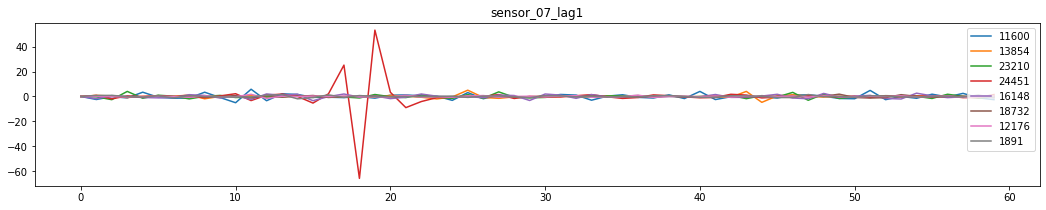

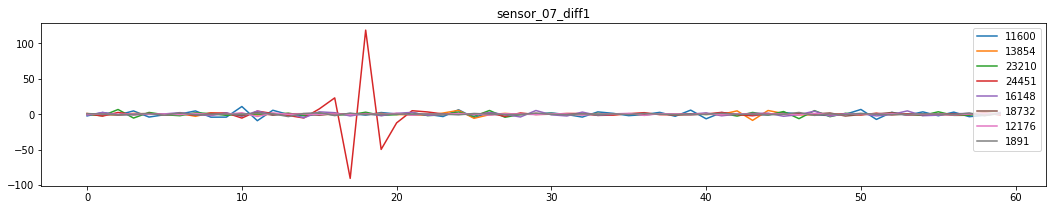

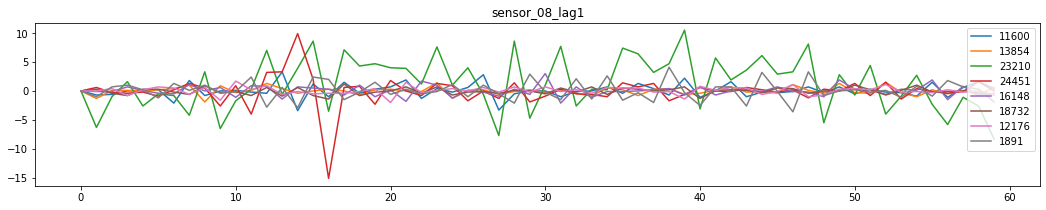

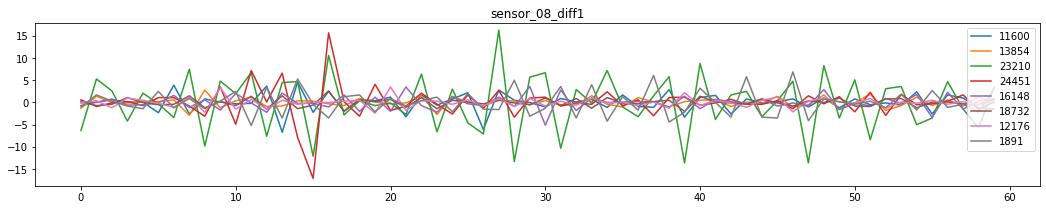

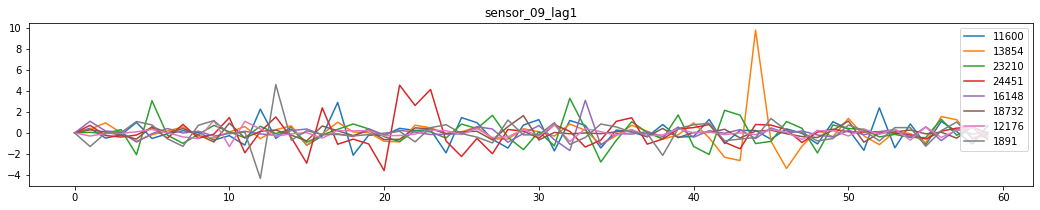

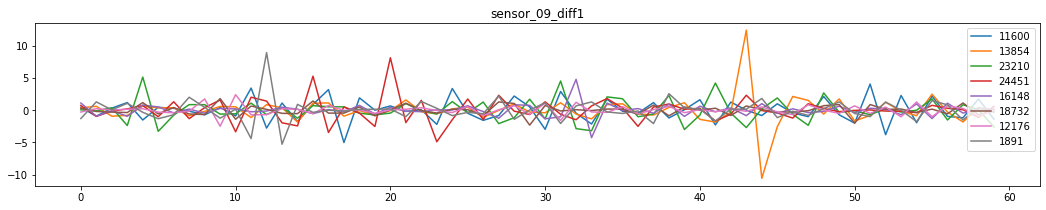

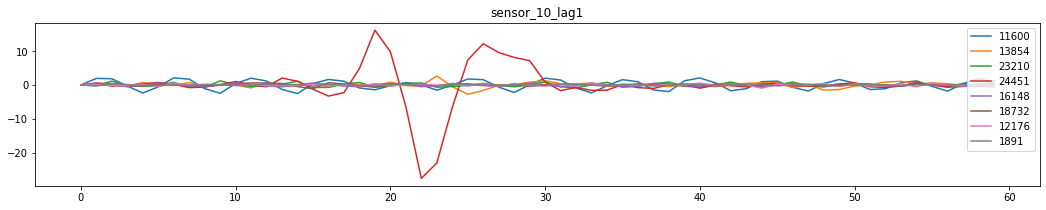

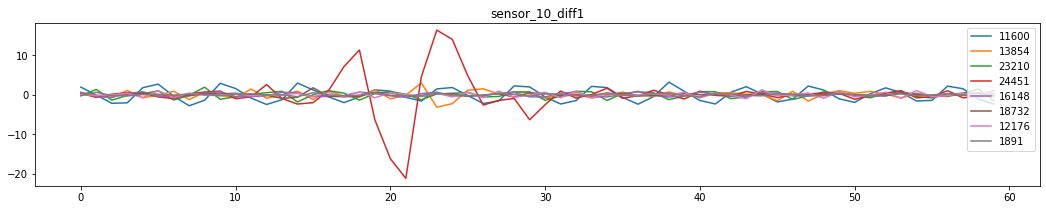

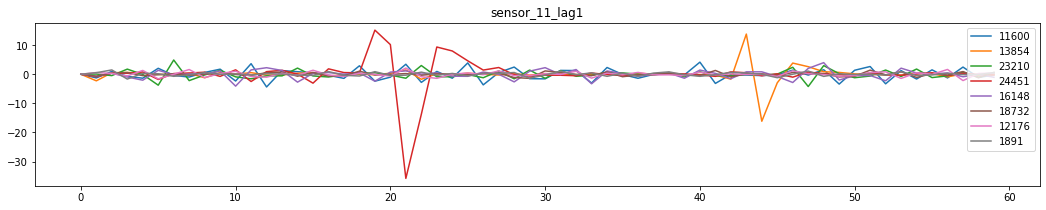

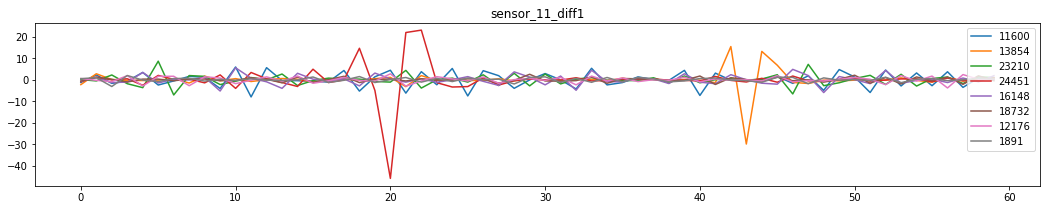

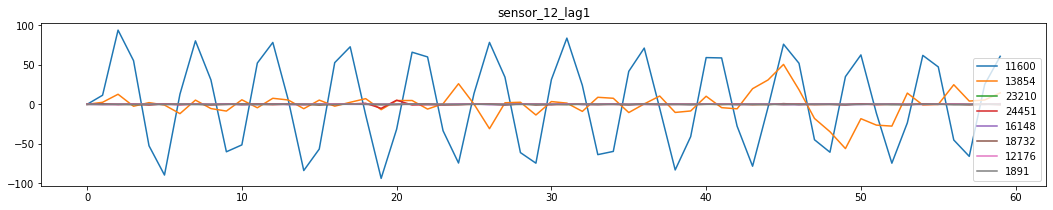

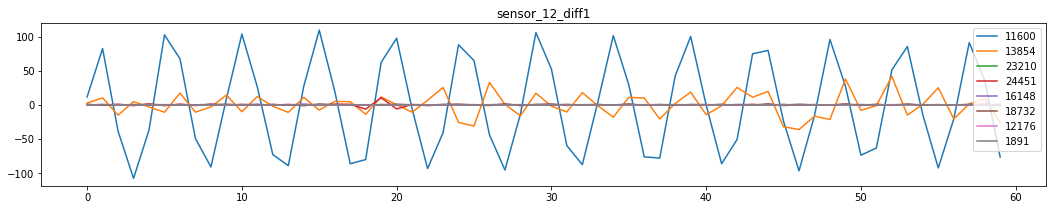

In [48]:
super_imp(sequences_0)

pass data through a function to remove noise while maintsing integrity of the data


In [49]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
mydata = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv', names = ['value'], header = 0) 
mydata
print(1)
#res=adfuller(mydata.value.dropna())
print(2)

#res

1
2


In [50]:
#dickey fuller test for stationarity since applying arima model p<0.005
no_adfs=[]
for i in range(25968):
    re=adfuller(mydata["value"][i])
    if re[1]<=0.005:
        pass
    else:
        no_adfs.append(i)
    if i in [25968,int(25968*(0.75)),int(25968*(0.5)),int(25968*(0.25)),0]:
        print(i,end=" ")

0 

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/

6492 

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


12984 

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


19476 

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [51]:
len(no_adfs),len(train)
len(mydata.value[0])

60

In [52]:
train["index"]=range(len(train))
a=train.set_index("sequence",False).drop(no_adfs,axis=0)
b=train.set_index("index")
tt=[]
for i in b.groupby(sort=False,by="sequence"):
    tt.append(i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  


In [53]:
train_2=a

In [71]:
#copied code for testing
def BuildNN():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(60, 42)),
        keras.layers.Bidirectional(keras.layers.LSTM(768, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
        keras.layers.Bidirectional(GRU(units=256,return_sequences=True)),
        keras.layers.Conv1D(32, 7),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(64, 3),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(50, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()])
    return model

In [55]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

In [56]:
'''tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)'''

'tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)'

# modifying feature 2 in train_2 and test

In [57]:
train_2.head()

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
sequence                                                                        
1                1       66     0  -6.657651  -0.141807  -2.332306  -0.715929   
1                1       66     1   1.633694   0.586134  -2.127622   5.637168   
1                1       66     2   1.863215  -2.143908  -1.999486  -4.159292   
1                1       66     3  -2.846213   2.011555  -1.999486  -1.711504   
1                1       66     4   0.593509  -0.613445  -1.999486   0.957522   

          sensor_04  sensor_05  sensor_06  ...  sensor_08_diff1  \
sequence                                   ...                    
1          0.789225  -0.483919  -4.568306  ...             -0.1   
1          0.613359  -1.287958  -0.885246  ...              0.6   
1         -1.417513   1.674645   2.775046  ...             -1.7   
1         -1.344486  -4.602842  -3.163024  ...              3.2   
1          0.457159   4.559461   2.064663  ...             -3.8   

          sensor_09_lag1  sensor_09_diff1  sensor_10_lag1  sensor_10_diff1  \
sequence                                                                     
1               0.000000        -3.517341        0.000000         1.168139   
1              -3.517341         4.149566        1.168139         0.013479   
1               0.632225         0.838873        1.181617        -3.100540   
1               1.471098        -3.272399       -1.918923         0.642749   
1              -1.801301         2.054913       -1.276174         2.712323   

          sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  sensor_12_diff1  \
sequence                                                                     
1               0.000000         1.524691        0.000000       -12.446718   
1               1.524691         0.862140      -12.446718        96.937766   
1               2.386831        -5.898148       84.491049      -120.429241   
1              -3.511317         4.363169      -35.938193      -124.296249   
1               0.851852        -0.740741     -160.234442       151.089088   

          index  
sequence         
1            60  
1            61  
1            62  
1            63  
1            64  

[5 rows x 44 columns]

In [58]:
"""a=train_2.corr()
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(a,annot=True)
R_2_n=[]
for i in range(4,len(a["sensor_02"])):
    if (a["sensor_02"][i]**2)**(0.5)>0.001:
        R_2_n.append(i-4)
R_2_n=R_2_n[:-1]
R_2_n"""

'a=train_2.corr()\nimport seaborn as sns\nplt.figure(figsize=(12,12))\nsns.heatmap(a,annot=True)\nR_2_n=[]\nfor i in range(4,len(a["sensor_02"])):\n    if (a["sensor_02"][i]**2)**(0.5)>0.001:\n        R_2_n.append(i-4)\nR_2_n=R_2_n[:-1]\nR_2_n'

In [59]:
"""s_2_n=[list(train_2["sensor_02"])]+[list(train_2["sensor_0"+str(i)]) for i in R_2_n]
trial=train_2.copy()
k=list(np.array(s_2_n[0])*(np.array(s_2_n[1])+(0.2)*np.array(s_2_n[2])))
trial["sensor_02"]=k
#/np.array(s_2_n[3])))
plt.figure(figsize=(12,13))
sns.heatmap(trial.corr(),annot=True)
trial"""

's_2_n=[list(train_2["sensor_02"])]+[list(train_2["sensor_0"+str(i)]) for i in R_2_n]\ntrial=train_2.copy()\nk=list(np.array(s_2_n[0])*(np.array(s_2_n[1])+(0.2)*np.array(s_2_n[2])))\ntrial["sensor_02"]=k\n#/np.array(s_2_n[3])))\nplt.figure(figsize=(12,13))\nsns.heatmap(trial.corr(),annot=True)\ntrial'

GOOD CORR IN 2 OBTAINED ,THERFORE NOT GOING TO DROP SENS-2 

In [60]:
'''train_2["sensor_02"]=k
s_2_n=[list(test["sensor_02"])]
s_2_n+=[list(test["sensor_0"+str(i)]) for i in R_2_n]
test["sensor_02"]=list(np.array(s_2_n[0])*(np.array(s_2_n[1])+(0.2)*np.array(s_2_n[2])))
train_2.head()
train_2=train_2.drop("index",axis=1)
train_2.head()'''

'train_2["sensor_02"]=k\ns_2_n=[list(test["sensor_02"])]\ns_2_n+=[list(test["sensor_0"+str(i)]) for i in R_2_n]\ntest["sensor_02"]=list(np.array(s_2_n[0])*(np.array(s_2_n[1])+(0.2)*np.array(s_2_n[2])))\ntrain_2.head()\ntrain_2=train_2.drop("index",axis=1)\ntrain_2.head()'

not doing any cahnges with sensor 2 as it leads to over fitting


# Adding other features


In [61]:
#sumation of different columns
s=train_2["sensor_00"]+train_2["sensor_01"]+train_2["sensor_06"]+train_2["sensor_09"]
s1=train_2["sensor_02"]+train_2["sensor_03"]+train_2["sensor_07"]+train_2["sensor_12"]
d=s-s1
train_2["sum_1"]=s
train_2["sum_2"]=s1
train_2["diff"]=d
"""plt.figure(figsize=(16,16))
sns.heatmap(train_2.corr(),annot=True)"""

'plt.figure(figsize=(16,16))\nsns.heatmap(train_2.corr(),annot=True)'

good results converting test too

In [62]:
s=test["sensor_00"]+test["sensor_01"]+test["sensor_06"]+test["sensor_09"]
s1=test["sensor_02"]+test["sensor_03"]+test["sensor_07"]+test["sensor_12"]
d=s-s1
test["sum_1"]=s
test["sum_2"]=s1
test["diff"]=d

# scalling data(standardization)

In [63]:
train_2=train_2.drop("index",axis=1)
train_2=train_2.drop("state",axis=1)

In [64]:
cul=train_2.columns
len(cul)


45

In [65]:
train_2.columns

Index(['sequence', 'subject', 'step', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_00_lag1', 'sensor_00_diff1', 'sensor_01_lag1',
       'sensor_01_diff1', 'sensor_02_lag1', 'sensor_02_diff1',
       'sensor_03_lag1', 'sensor_03_diff1', 'sensor_04_lag1',
       'sensor_04_diff1', 'sensor_05_lag1', 'sensor_05_diff1',
       'sensor_06_lag1', 'sensor_06_diff1', 'sensor_07_lag1',
       'sensor_07_diff1', 'sensor_08_lag1', 'sensor_08_diff1',
       'sensor_09_lag1', 'sensor_09_diff1', 'sensor_10_lag1',
       'sensor_10_diff1', 'sensor_11_lag1', 'sensor_11_diff1',
       'sensor_12_lag1', 'sensor_12_diff1', 'sum_1', 'sum_2', 'diff'],
      dtype='object')

In [66]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
b=sc.fit_transform(train_2)
a=sc.transform(test)
a=pd.DataFrame(a)
b=pd.DataFrame(b)
test=a.set_axis(cul,axis="columns")
train_2=b.set_axis(cul,axis="columns")


In [67]:
test.head()

sequence   subject      step  sensor_00  sensor_01  sensor_02  sensor_03  \
0  1.734958  1.806174 -1.703420   0.908764   4.442458   0.529877  -0.369869   
1  1.734958  1.806174 -1.645677  -1.854051  -4.918811   0.529877   0.248991   
2  1.734958  1.806174 -1.587934   0.425192  -2.432673   0.529877   0.257487   
3  1.734958  1.806174 -1.530191   0.301622   1.471400   0.529877  -0.044789   
4  1.734958  1.806174 -1.472448   0.482202   1.256143   0.529877  -0.124158   

   sensor_04  sensor_05  sensor_06  ...  sensor_09_diff1  sensor_10_lag1  \
0  -0.762745  -2.634933   0.736829  ...        -0.273256       -0.000361   
1  -0.335953   1.157362  -1.151883  ...         0.369437       -0.877436   
2   0.571720   1.538746   0.092686  ...         0.174889       -0.462861   
3   0.574719  -0.647422  -0.135341  ...        -0.414203        0.799245   
4  -0.612464  -0.704583   0.595156  ...         0.362056        0.318775   

   sensor_10_diff1  sensor_11_lag1  sensor_11_diff1  sensor_12_lag1  \
0        -0.748631        0.000947         1.527289        0.000066   
1         0.353900        2.424395        -1.787647        0.010542   
2         1.077338       -0.412082        -1.351045       -0.000147   
3        -0.410096       -2.555788         1.021284        0.003561   
4        -0.836037       -0.935236         0.524294       -0.011507   

   sensor_12_diff1     sum_1     sum_2      diff  
0         0.008701  2.476321 -0.056478  0.612955  
1        -0.008508 -3.191046  0.096217 -0.812691  
2         0.003199 -0.866070  0.086646 -0.279512  
3        -0.012069  0.662029  0.020651  0.129059  
4         0.007124  1.030303 -0.002784  0.234858  

[5 rows x 45 columns]

In [68]:
train=train_2
groups = train["sequence"]
train = train.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
test = test.drop(["sequence", "subject", "step"], inplace=False, axis=1).values
labels = train_labels["state"]
labels=labels.drop(no_adfs,axis=0)
train = train.reshape(int(len(train)/60), 60, 42)
test = test.reshape(int(len(test)/60), 60, 42)

In [69]:
train.shape
len(train)

23255

In [72]:
cv_score = 0
test_preds = []
kf = GroupKFold(n_splits=5)
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train, labels, groups.unique())):
    
    print("*"*15, f"Fold {fold_idx+1}", "*"*15)
    
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = labels.iloc[train_idx].values, labels.iloc[valid_idx].values
    
    model = BuildNN()
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=256, 
              callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    cv_score += roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    
    test_preds.append(model.predict(test).squeeze())
    
print(cv_score/5)

*************** Fold 1 ***************


2022-04-13 15:58:11.721787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-13 15:58:19.213781: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - 36s 307ms/step - loss: 0.5407 - auc: 0.8017 - val_loss: 0.4439 - val_auc: 0.8756
Epoch 2/50
73/73 [==============================] - 21s 283ms/step - loss: 0.3897 - auc: 0.9044 - val_loss: 0.3994 - val_auc: 0.9009
Epoch 3/50
73/73 [==============================] - 21s 283ms/step - loss: 0.3403 - auc: 0.9281 - val_loss: 0.3445 - val_auc: 0.9341
Epoch 4/50
73/73 [==============================] - 21s 283ms/step - loss: 0.3076 - auc: 0.9419 - val_loss: 0.3195 - val_auc: 0.9403
Epoch 5/50
73/73 [==============================] - 21s 282ms/step - loss: 0.2851 - auc: 0.9502 - val_loss: 0.3171 - val_auc: 0.9451
Epoch 6/50
73/73 [==============================] - 21s 282ms/step - loss: 0.2484 - auc: 0.9622 - val_loss: 0.3100 - val_auc: 0.9497
Epoch 7/50
73/73 [==============================] - 21s 282ms/step - loss: 0.2293 - auc: 0.9678 - val_loss: 0.2993 - val_auc: 0.9466
Epoch 8/50
73/73 [==============================] - 21s 282ms/step - loss: 0.200

In [ ]:
submission=pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

In [ ]:
submission["state"] = sum(test_preds)/5
ans=[]
for i in submission["state"]:
    ans.append(i)

In [ ]:
submission.to_csv("submission.csv", index=False)
submission

feature 14 ->area under 13 sided polygon() 